In [1]:
import pandas as pd
import networkx as nx
import pygraphviz as pgv
from path_calc import Solver
from matplotlib import pyplot as plt
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr


In [2]:
G = nx.read_weighted_edgelist('collectri_network_sscp.sif', delimiter = '\t', create_using = nx.DiGraph)

# 2. Iterate through each edge and 3. Set attributes
for u, v, data in G.edges(data=True):
    weight = data['weight']
    data['sign'] = 1 if weight >= 0 else -1
    data['weight'] = abs(weight)


# Trynska data

In [3]:
target_df = pd.read_csv('downstream_hits.tsv', sep='\t', header=None)
target_df.drop(1, inplace=True, axis=1)
target_df

,0,2
0,CINP,+
1,ATP1B1,+
2,DNAJC12,+
3,SCCPDH,+
4,IDS,+
...,...,...
95,IKZF1,-
96,SDHD,+
97,RASGRP3,+
98,BIRC6,-


In [4]:
target_df[2].replace({'+': 1, '-': -1}, inplace=True)

target_dict = target_df.set_index(0)[2].to_dict()


In [5]:
# Removes targets not present in the network
filtered_target_dict = {key: value for key, value in target_dict.items() if key in G.nodes()}

In [6]:
G1P_solver = Solver(G, 'trynska')
G1P_solver.source_dict = {'TGFB1': 1, 'TGFB2': 1, 'TGFB3': 1, 'IL2': 1}
filtered_target_dict = {key: value for key, value in target_dict.items() if key in G.nodes() and key not in G1P_solver.source_dict.keys()}
G1P_solver.target_dict = filtered_target_dict
# G1P_solver.runinfo_df = pd.read_csv('./results/trynska_runinfo.csv', index_col=0)

Computing path 1 with threshold 0.01
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.009
Computing path 1 with threshold 0.008
Computing path 1 with threshold 0.007
Computing path 1 with threshold 0.006
Computing path 1 with threshold 0.005
Computing path 1 with threshold 0.004
Computing path 1 with threshold 0.003
Computing path 1 with threshold 0.002
Computing path 1 with threshold 0.001
Computing path 1 with threshold 0.0
The graph is too large to visualize. It has 717 edges.
Computing path 2 with threshold 0.01
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 2 with threshold 0.009
Computing path 2 with threshold 0.008
Computing path 2 with threshold 0.007
Computing path 2 with threshold 0.006
Computing path 2 with threshold 0.005
Computing path 2 with threshold 0.004
Computing path 2 with threshold 0.003
Computing path 2 with threshold 0.002
Computing pat

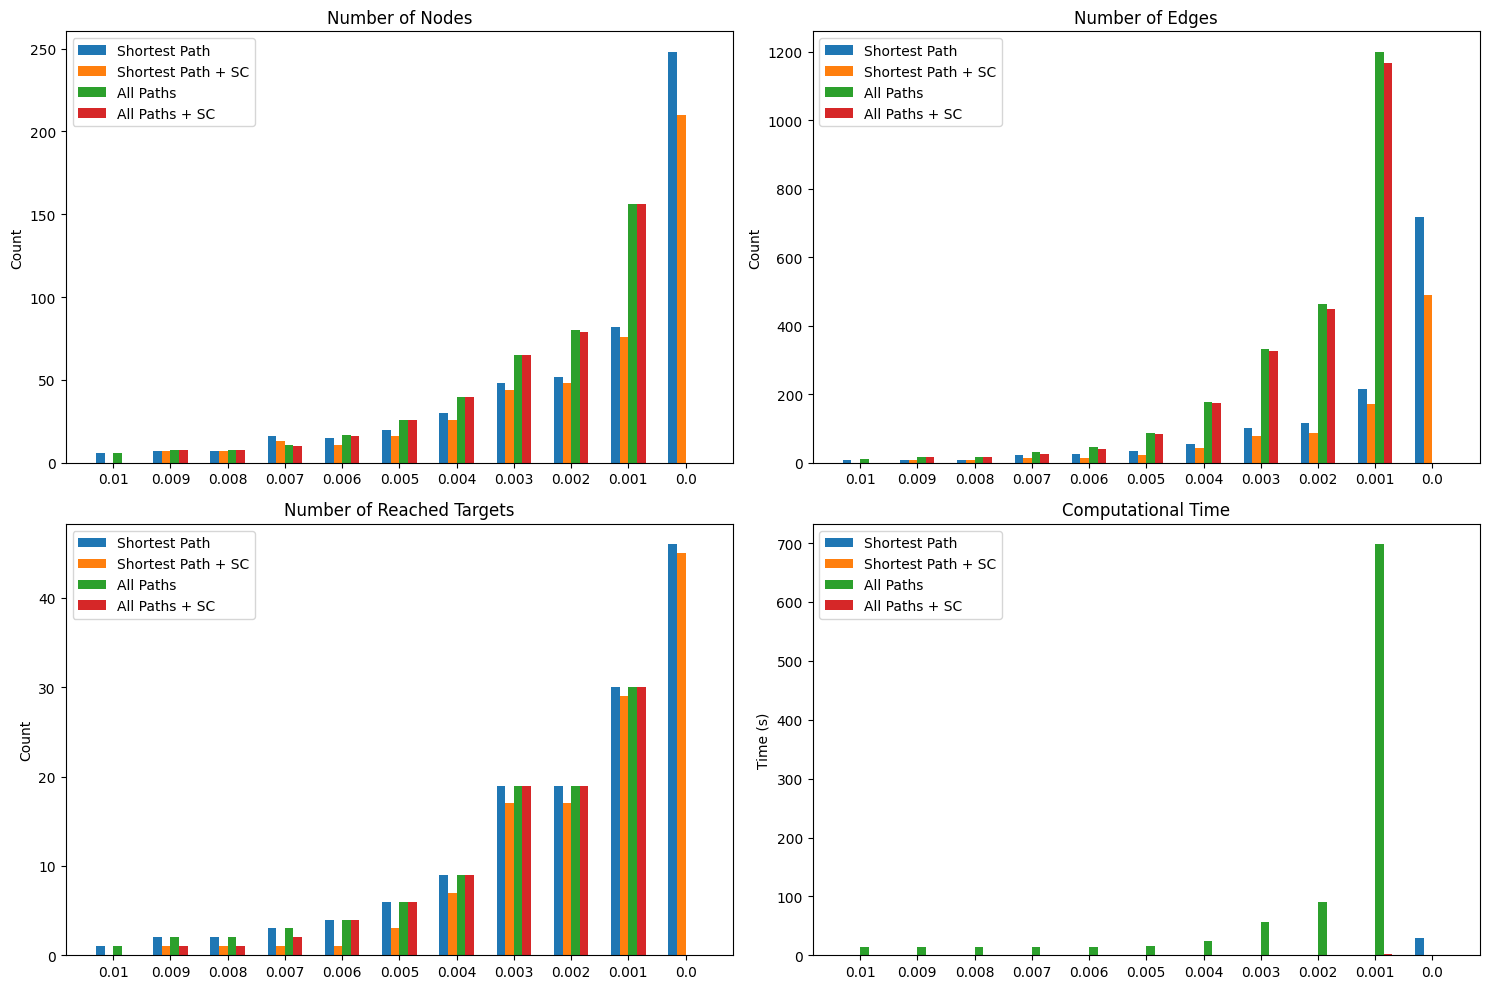

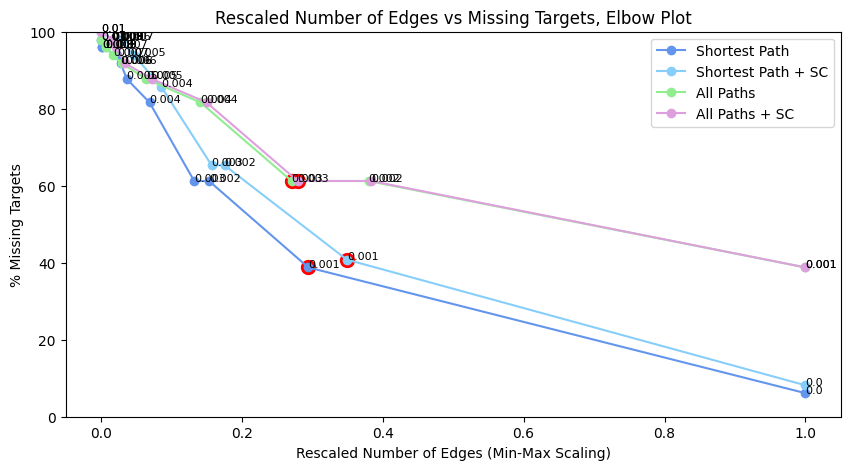

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

__pagerank_0.0__shortest v.s. __pagerank_0.0__shortest__sc: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.529e+04
__pagerank_0.0__shortest__sc v.s. __pagerank_0.001__shortest: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.583e-16 U_stat=3.160e+03
__pagerank_0.001__shortest v.s. __pagerank_0.001__shortest__sc: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.016e+03
__pagerank_0.001__shortest__sc v.s. __pagerank_0.003__reachability__allpaths: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.626e-07 U_stat=1.161e+03
__pagerank_0.003__reachability__allpaths v.s. __pagerank_0.003__reachability__allpaths__sc: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=

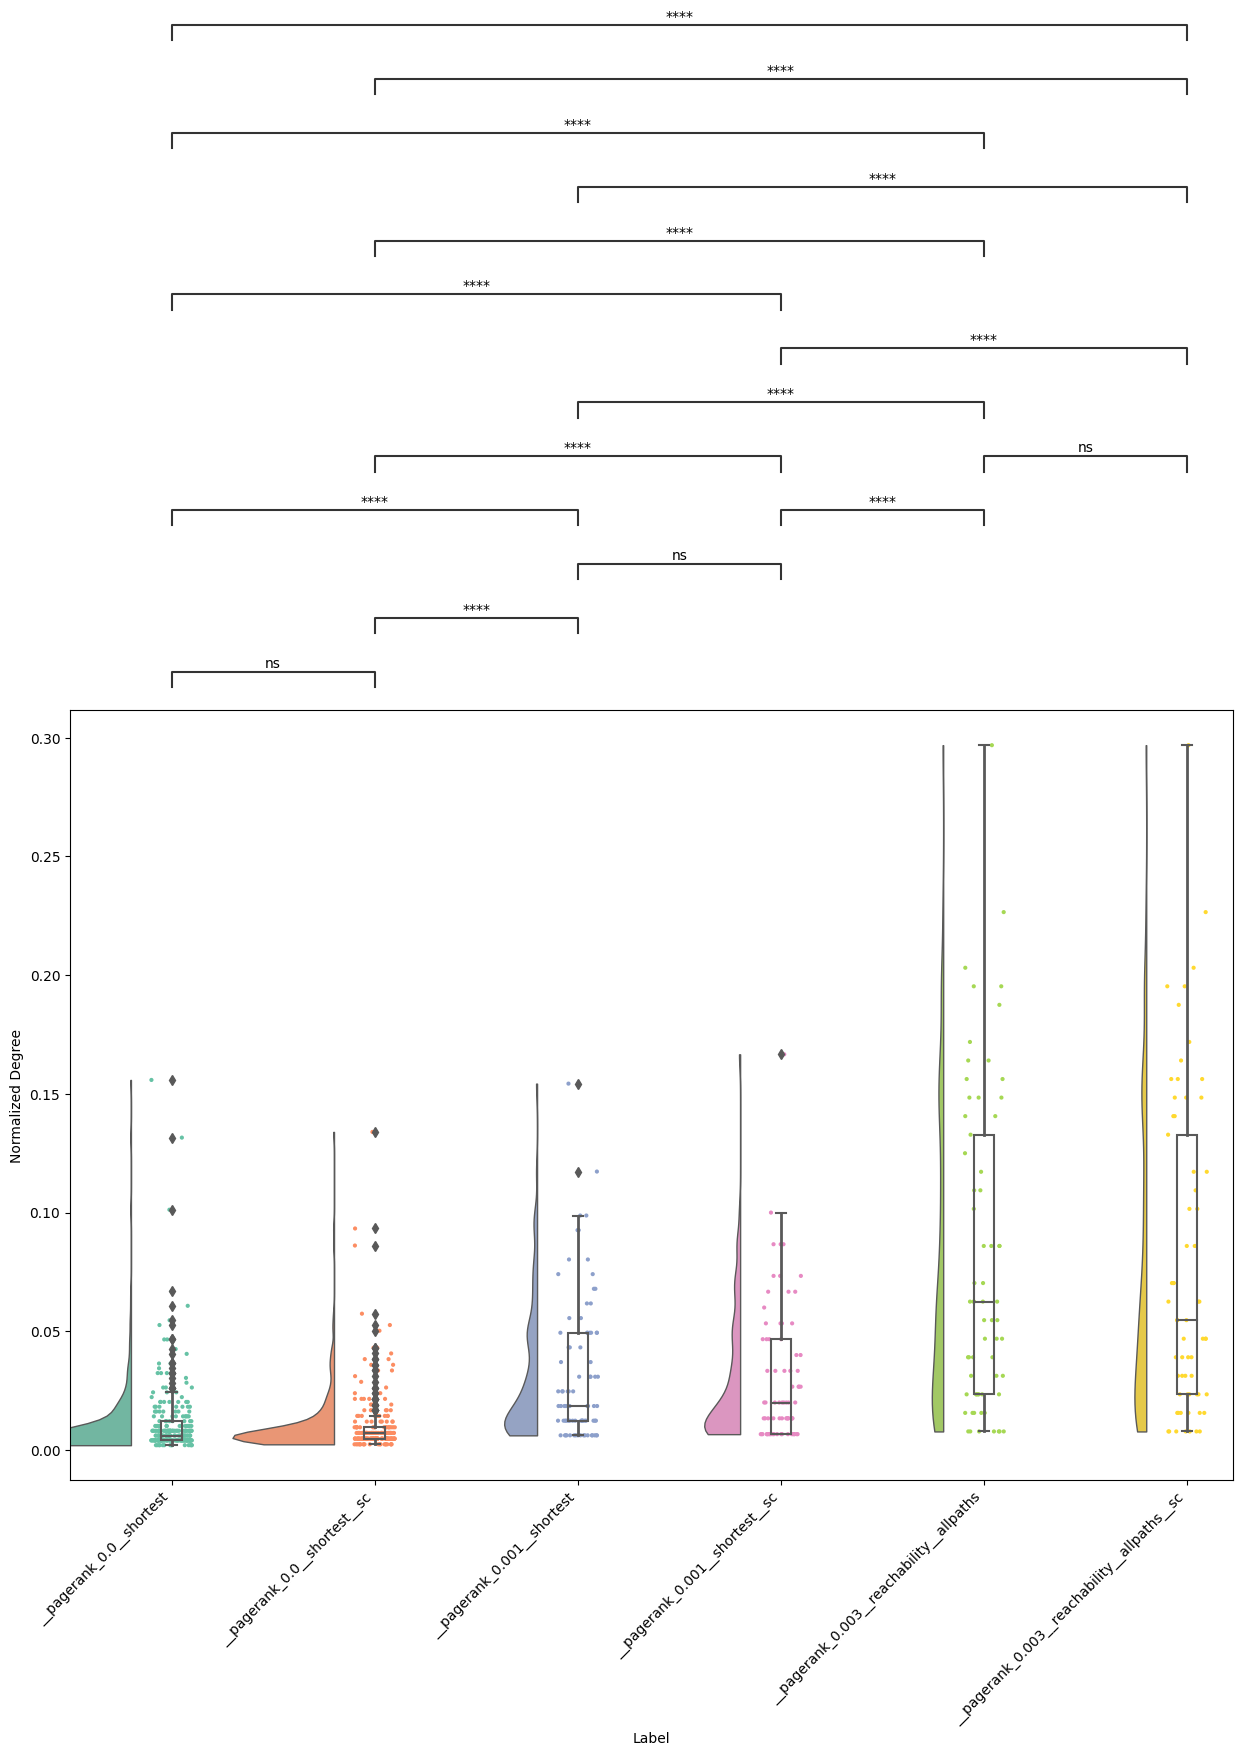

['trynska__reachability__pagerank_0.0__shortest__sc.sif', 'trynska__reachability__pagerank_0.0__shortest.sif', 'trynska__reachability__pagerank_0.003__reachability__allpaths.sif', 'trynska__reachability__pagerank_0.001__shortest__sc.sif', 'trynska__reachability__pagerank_0.003__reachability__allpaths__sc.sif', 'trynska__reachability__pagerank_0.001__shortest.sif']


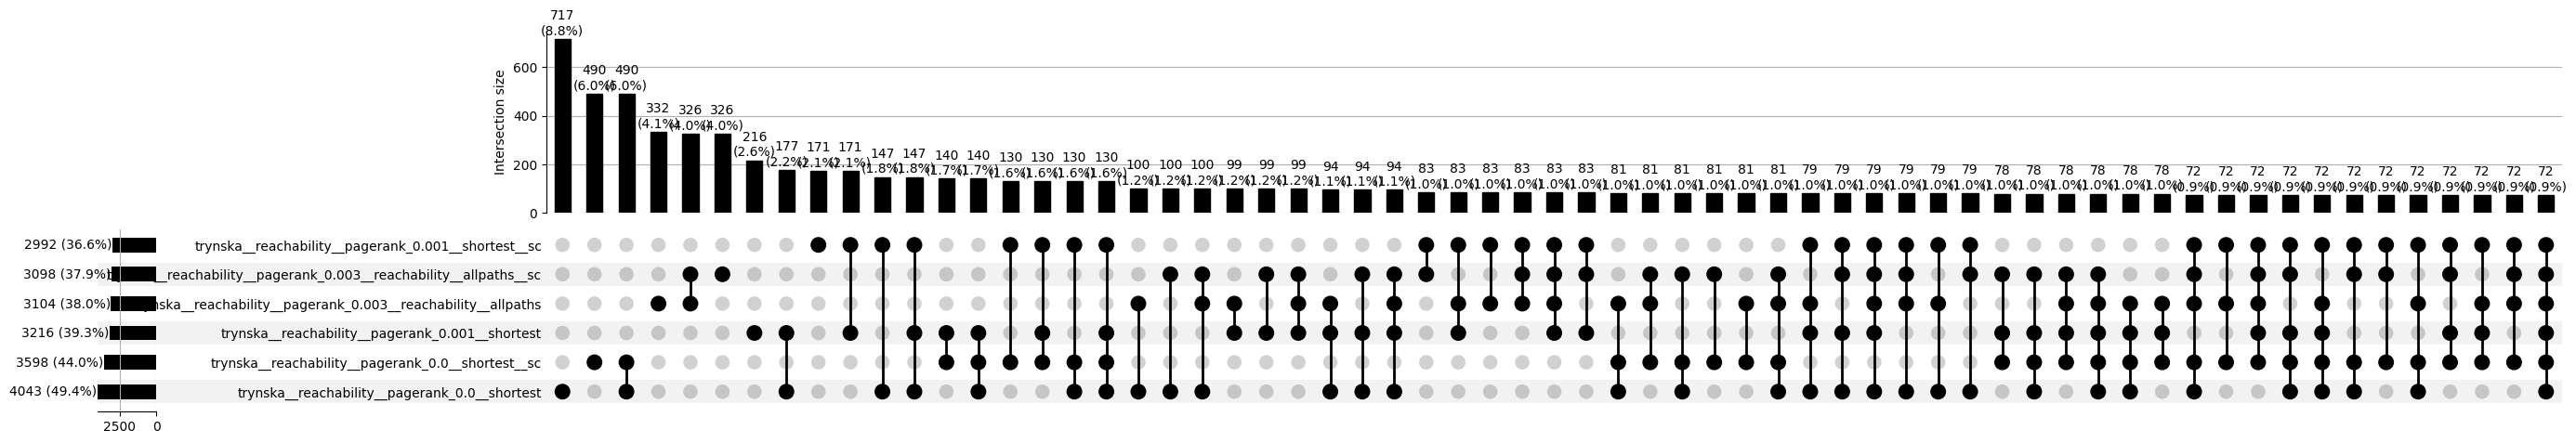

In [7]:
G1P_solver.network_batchrun(cutoff = 6)

### Comments

In the first plot, we see that the number of connected targets when using the all_paths approach actually peak at a lower % than when using the shortest_path approach. This is due to the extra constrain added by the cutoff value in the all paths option. When setting low cutoff values, many of the targets are actually not reachable when using less edges than the cutoff value. However, this constrain is not present in the second path, thus showing better performance. When looking at the orange line (size of network in all paths option) we see that incorporating more nodes via lowering the pagerank threshold does not actually help in connecting more targets. Probably what we are facing here is a depth problem: widening the network does not help because the targets are in a level deeper than the one we can reach. Further steps would be testing higher cutoffs, but the computational time explodes. Maybe in the cluster it's faster, will try this in subsequent iterations. 

# GSE106159

The goals of this study are to compare the U87 cell xenograft GBM mice (U87 cell line) to TWIST1 knock out U87 cell xenograft GBM mice (TWIST1 knock out U87 cell line) using their transcriptomes. 

TWIST1 (TW) is a bHLH transcription factor (TF) and master regulator of the epithelial‐to‐mesenchymal transition (EMT). In vitro, TW promotes mesenchymal change, invasion, and self‐renewal in glioblastoma (GBM) cells. However, the potential therapeutic relevance of TW has not been established through loss‐of‐function studies in human GBM cell xenograft models. The effects of TW loss of function (gene editing and knockdown) on inhibition of tumorigenicity of U87MG and GBM4 glioma stem cells were tested in orthotopic xenograft models and conditional knockdown in established flank xenograft tumors. RNAseq and the analysis of tumors investigated putative TW‐associated mechanisms. Multiple bioinformatic tools revealed significant alteration of ECM, membrane receptors, signaling transduction kinases, and cytoskeleton dynamics leading to identification of PI3K/AKT signaling. We experimentally show alteration of AKT activity and periostin (POSTN) expression in vivo and/or in vitro. For the first time, we show that effect of TW knockout inhibits AKT activity in U87MG cells in vivo independent of PTEN mutation. The clinical relevance of TW and candidate mechanisms was established by analysis of the TCGA and ENCODE databases. TW expression was associated with decreased patient survival and LASSO regression analysis identified POSTN as one of top targets of TW in human GBM. While we previously demonstrated the role of TW in promoting EMT and invasion of glioma cells, these studies provide direct experimental evidence supporting protumorigenic role of TW independent of invasion in vivo and the therapeutic relevance of targeting TW in human GBM. Further, the role of TW driving POSTN expression and AKT signaling suggests actionable targets, which could be leveraged to mitigate the oncogenic effects of TW in GBM.

In [8]:
# Load dataset
gex_GEO = pd.read_csv('GSE106159-expression.txt', sep='\t', index_col=0)
meta_GEO = pd.read_csv('GSE106159-metadata.txt', sep='\t', index_col=0)

# Preview expression data
gex_GEO.head()

,GSM2830596,GSM2830597,GSM2830598,GSM2830599,GSM2830600,GSM2830601,GSM2830602,GSM2830603,GSM2830604,GSM2830605,...,GSM2830609,GSM2830610,GSM2830611,GSM2830612,GSM2830613,GSM2830614,GSM2830615,GSM2830616,GSM2830617,GSM2830618
gene_symbol,,,,,,,,,,,,,,,,,,,,,
A1BG,24,15,11,29,23,19,39,65,58,47,...,49,44,26,38,26,38,46,29,44,46
A1CF,6,6,7,10,14,11,3,7,14,4,...,6,14,13,18,8,20,21,23,22,24
A2M,112,129,115,166,156,232,218,7,8,10,...,1,3,0,1,0,0,0,0,4,1
A2ML1,14,6,4,10,4,8,10,19,12,9,...,9,16,17,13,15,20,22,9,13,18
A2MP1,0,0,0,1,0,0,1,1,0,0,...,1,0,0,3,1,2,1,2,1,1


In [9]:
meta_GEO.head()

,Sample Title,genotype,tissue
Sample_geo_accession,,,
GSM2830596,U87_tumor_TW_676_rep1,TWIST1 Wild,Brain
GSM2830597,U87_tumor_TW_677_rep1,TWIST1 Wild,Brain
GSM2830598,U87_tumor_TW_677_rep2,TWIST1 Wild,Brain
GSM2830599,U87_tumor_TW_679_rep1,TWIST1 Wild,Brain
GSM2830600,U87_tumor_TW_679_rep2,TWIST1 Wild,Brain


In [10]:
# pandas2ri.activate()

# base = importr('base')
# stats = importr('stats')
# DESeq2 = importr('DESeq2')

# import pandas as pd

# col_data = meta_GEO[['genotype']]
# col_data['genotype'] = stats.relevel(robjects.FactorVector(col_data['genotype']), ref="TWIST1 Wild")

# dds = DESeq2.DESeqDataSetFromMatrix(countData=gex_GEO, colData=col_data, design=robjects.Formula("~ genotype"))

# dds = DESeq2.DESeq(dds)

# res = DESeq2.results(dds)

# res_df = robjects.r['as.data.frame'](res)
# res_df_pandas = robjects.conversion.rpy2py(res_df)

# de_GEO = res_df_pandas.sort_values(by='stat', ascending=False, key=lambda col: col.abs())

# de_GEO.to_csv('GSE106159_de.csv', sep='\t', index=True)

# de_GEO

In [11]:
de_GEO = pd.read_csv('GSE106159_de.csv', sep='\t', index_col=0)
de_GEO

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
MAGEA6,320.473919,-8.499931,0.304161,-27.945474,7.482433e-172,1.636333e-167
MAGEA1,519.461428,-9.616276,0.348760,-27.572744,2.362408e-167,2.583175e-163
CD33,97.587967,-3.863992,0.178690,-21.623990,1.068292e-103,7.787495e-100
NAXD,662.275231,1.193964,0.058426,20.435620,8.066174e-93,4.409979e-89
PDE10A,190.518468,-1.794220,0.088274,-20.325562,7.640894e-92,3.341974e-88
...,...,...,...,...,...,...
ZNRF4,0.000000,NaN,NaN,NaN,NaN,NaN
ZSCAN1,0.000000,NaN,NaN,NaN,NaN,NaN
ZSWIM5P2,0.000000,NaN,NaN,NaN,NaN,NaN
ZYG11AP1,0.000000,NaN,NaN,NaN,NaN,NaN


In [12]:
de_GEO_subset = de_GEO.head(100)

In [13]:
targetsdf_GEO = de_GEO_subset[['stat']]

targetsdf_GEO['stat'] = np.where(targetsdf_GEO['stat'] > 0, 1, np.where(targetsdf_GEO['stat'] < 0, -1, targetsdf_GEO['stat']))

target_GEO = targetsdf_GEO['stat'].to_dict()


/tmp/ipykernel_26181/2814781389.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targetsdf_GEO['stat'] = np.where(targetsdf_GEO['stat'] > 0, 1, np.where(targetsdf_GEO['stat'] < 0, -1, targetsdf_GEO['stat']))


In [14]:
G2P_solver = Solver(G, 'GSE106159')
G2P_solver.source_dict = {'TWIST1': -1}
filtered_target_dict = {key: value for key, value in target_GEO.items() if key in G.nodes() and key not in G2P_solver.source_dict.keys()}
G2P_solver.target_dict = filtered_target_dict

Computing path 1 with threshold 0.01
Computing path 1 with threshold 0.009
Computing path 1 with threshold 0.008
Computing path 1 with threshold 0.007
Computing path 1 with threshold 0.006
Computing path 1 with threshold 0.005
Computing path 1 with threshold 0.004
Computing path 1 with threshold 0.003
Computing path 1 with threshold 0.002
Computing path 1 with threshold 0.001
Computing path 1 with threshold 0.0
Computing path 2 with threshold 0.01
Computing path 2 with threshold 0.009
Computing path 2 with threshold 0.008
Computing path 2 with threshold 0.007
Computing path 2 with threshold 0.006
Computing path 2 with threshold 0.005
Computing path 2 with threshold 0.004
Computing path 2 with threshold 0.003
Computing path 2 with threshold 0.002
Computing path 2 with threshold 0.001


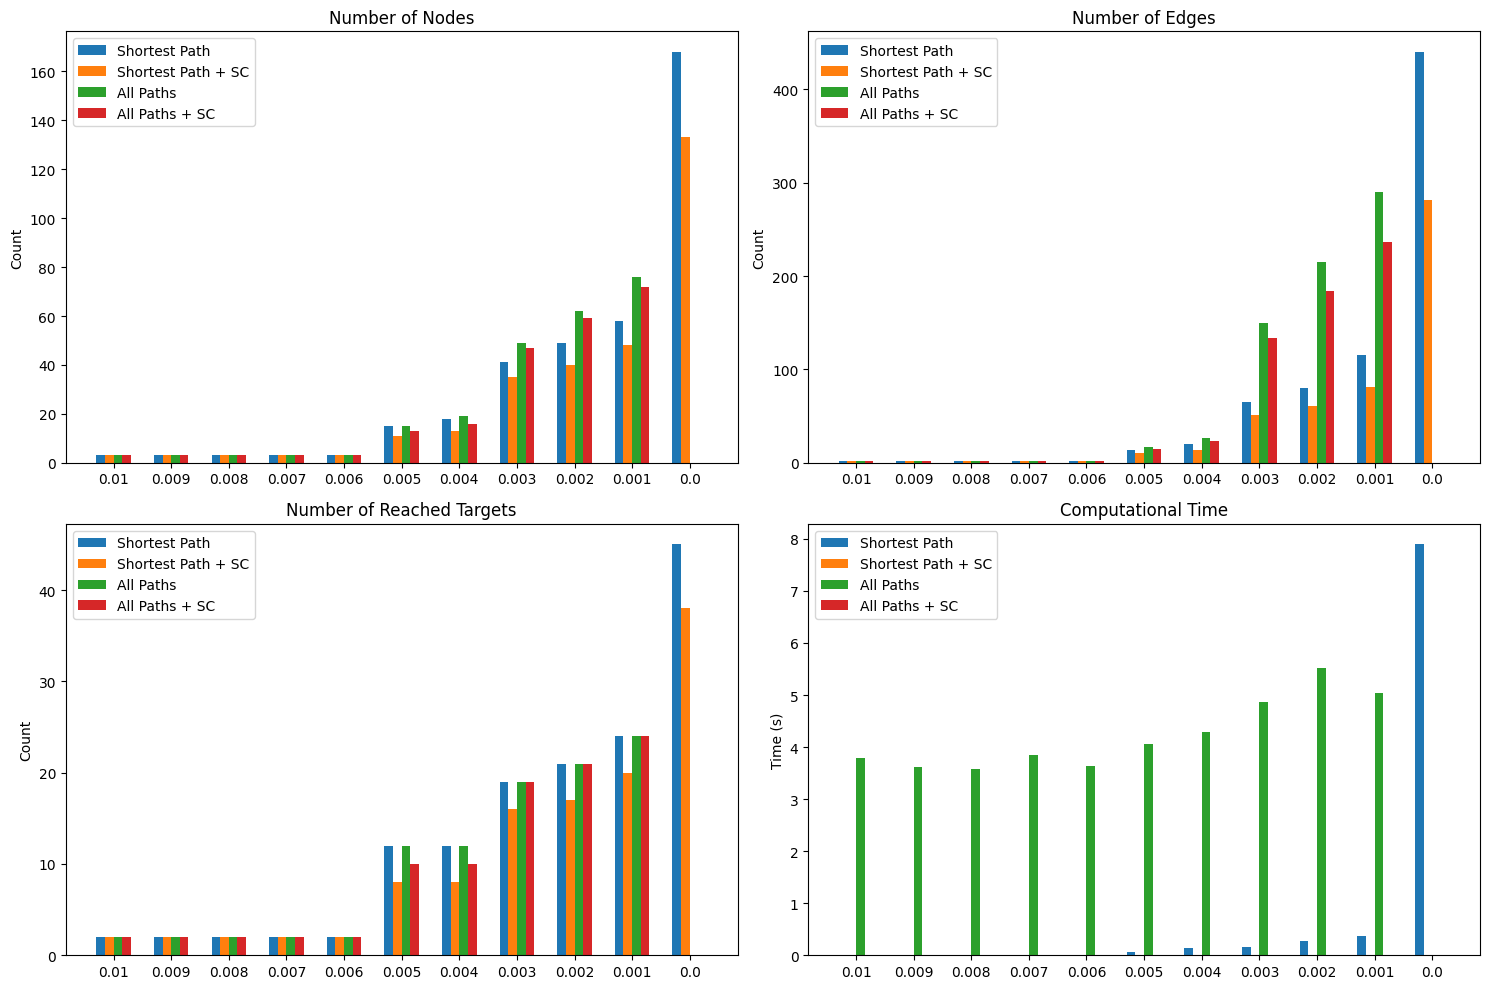

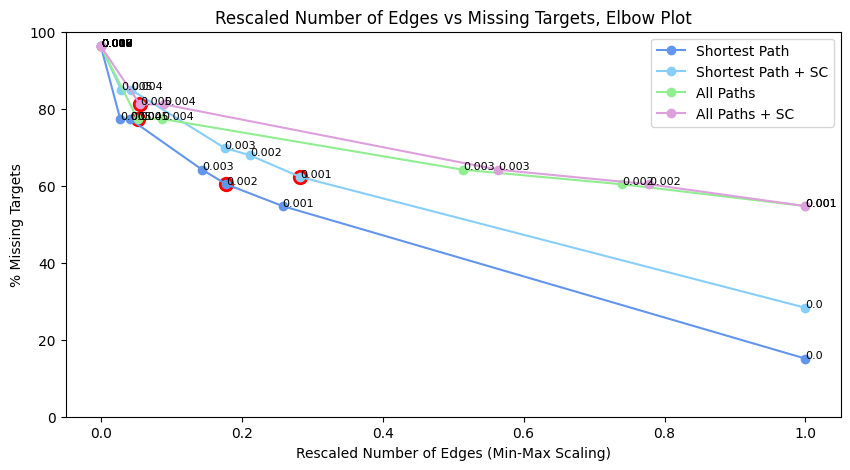

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

__pagerank_0.0__shortest v.s. __pagerank_0.0__shortest__sc: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.031e+04
__pagerank_0.0__shortest__sc v.s. __pagerank_0.002__shortest: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.335e-05 U_stat=1.778e+03
__pagerank_0.002__shortest v.s. __pagerank_0.001__shortest__sc: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.247e-01 U_stat=8.130e+02
__pagerank_0.001__shortest__sc v.s. __pagerank_0.005__reachability__allpaths: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.500e-03 U_stat=1.490e+02
__pagerank_0.005__reachability__allpaths v.s. __pagerank_0.005__reachability__allpaths__sc: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.730e-01 U_stat=

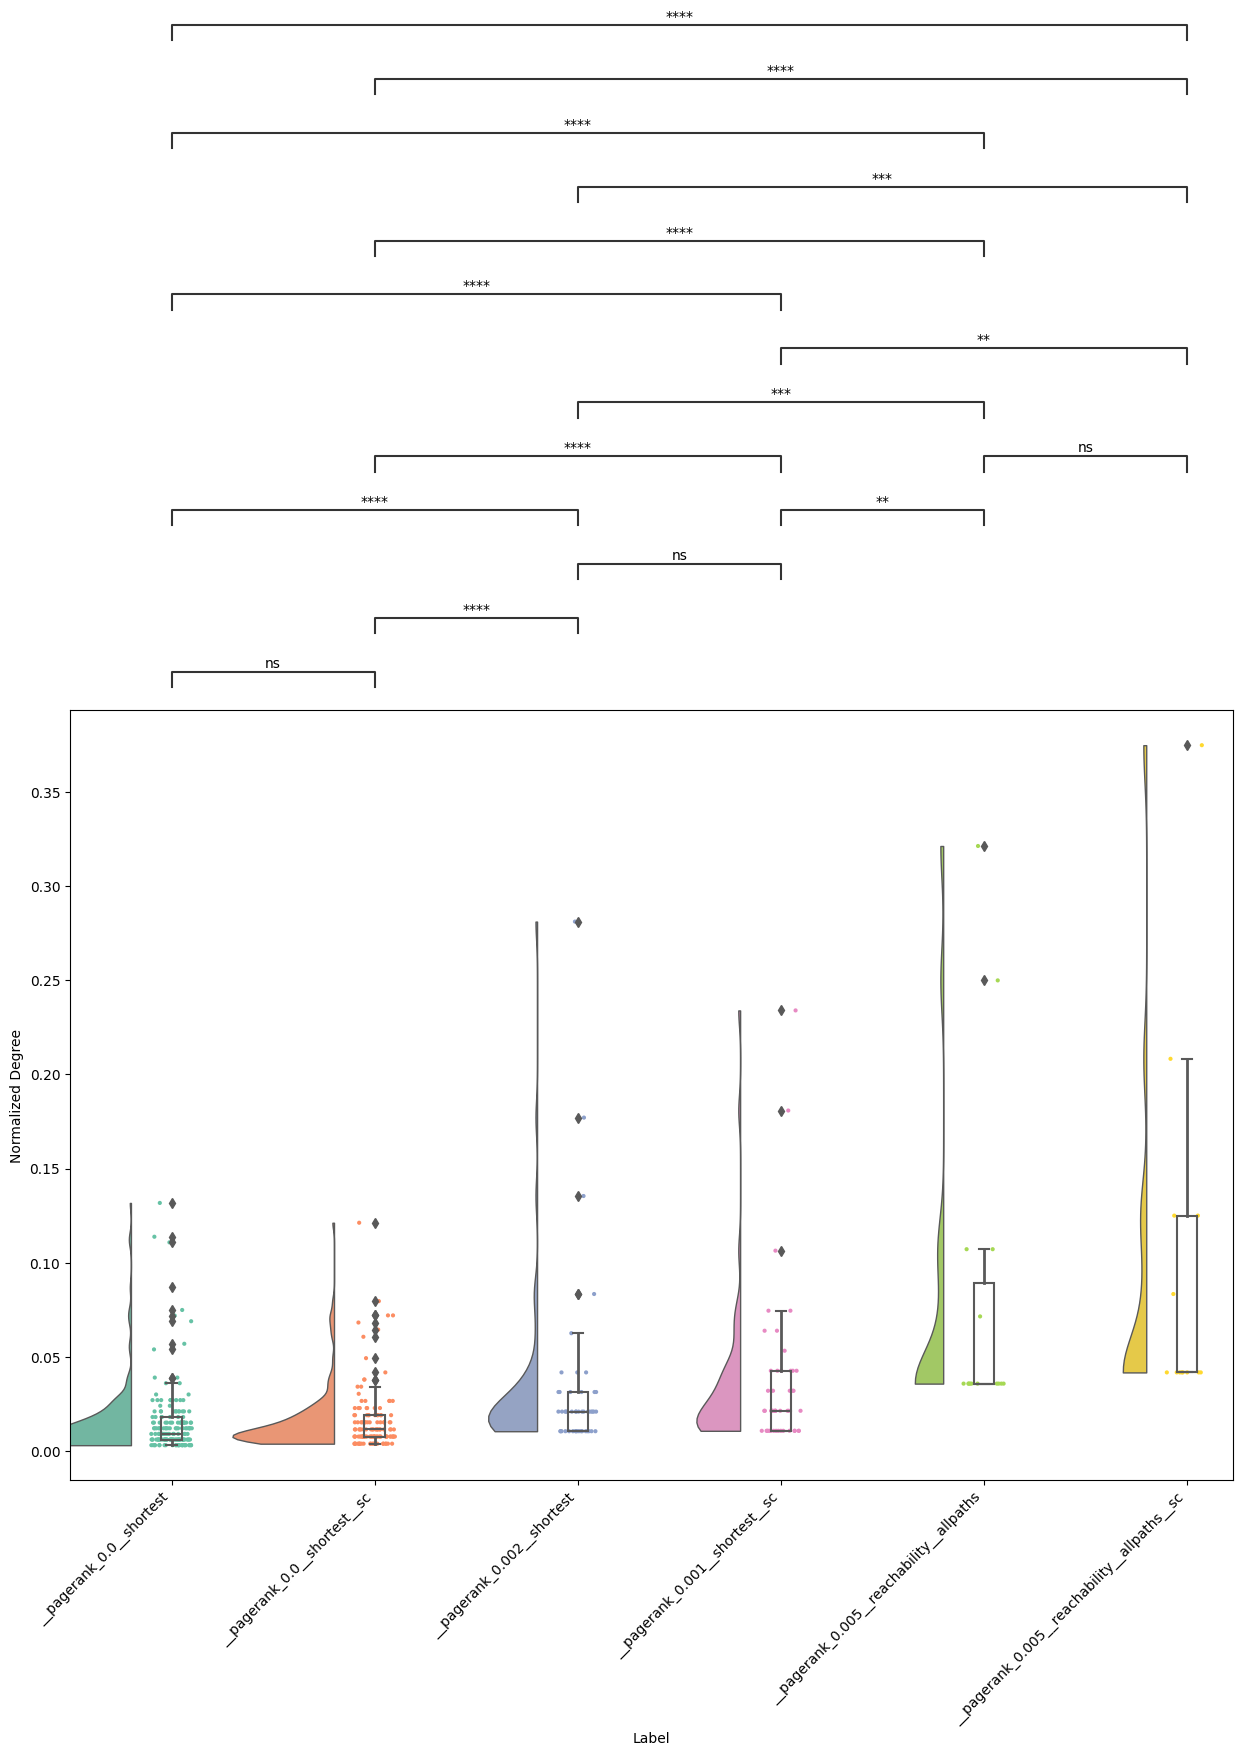

['GSE106159__reachability__pagerank_0.0__shortest.sif', 'GSE106159__reachability__pagerank_0.0__shortest__sc.sif', 'GSE106159__reachability__pagerank_0.005__reachability__allpaths__sc.sif', 'GSE106159__reachability__pagerank_0.005__reachability__allpaths.sif', 'GSE106159__reachability__pagerank_0.002__shortest.sif', 'GSE106159__reachability__pagerank_0.001__shortest__sc.sif']


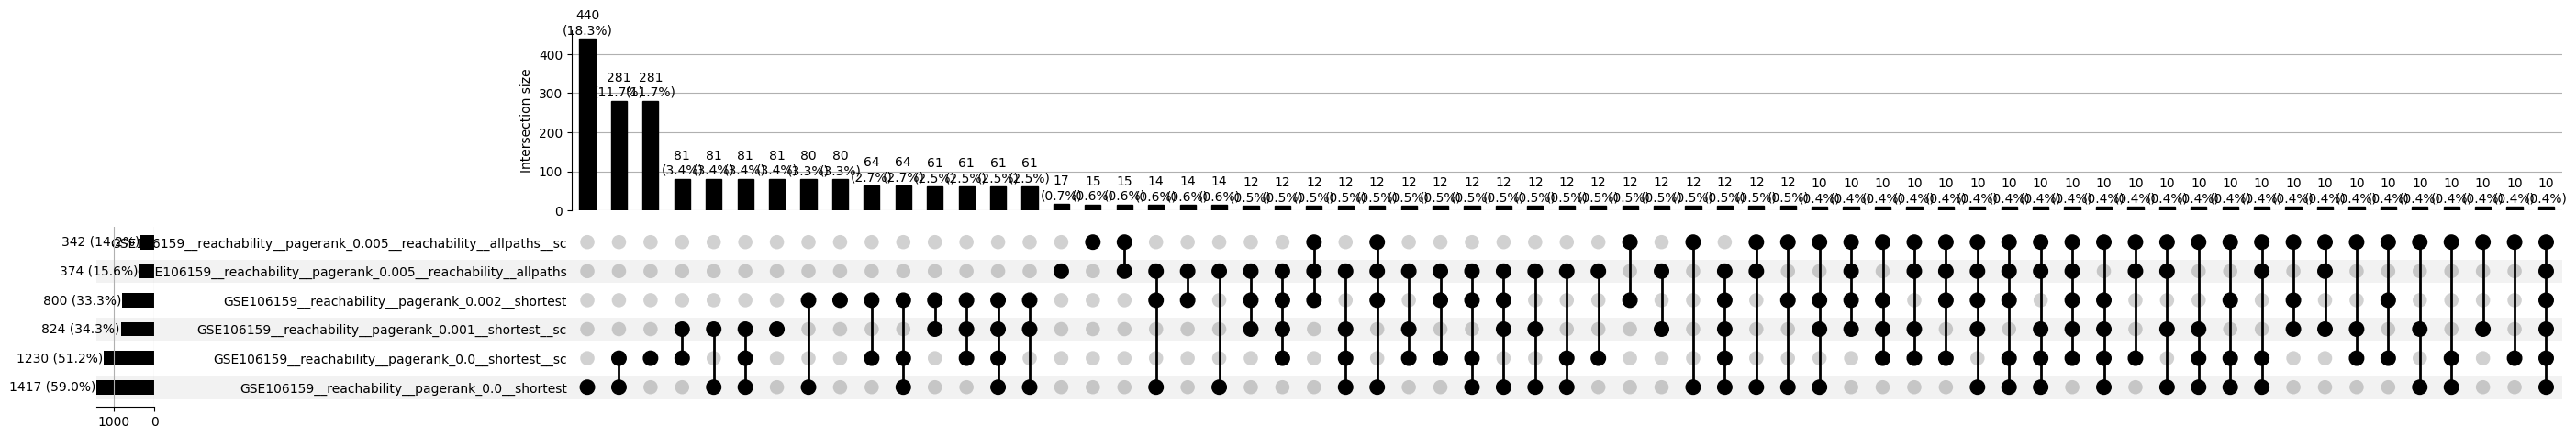

In [15]:
G2P_solver.network_batchrun()

### Comments

In this case, we observe the expected behaviour: the number of elements connected is higher when using the all_paths option. The reason for this is that, by doing pagerank threshold>all_paths>sign_consistency>shortest_path, we actually prioritise nodes that are sign consistent over the shortest paths. Therefore, many targets will be connected via paths that are sign consistent but not shortest and thus, not appearing in our other option (pagerank_threshold>shortest_path>sign_consistency).

# GSE115311

Dysfunction of blood vessels leads to severe vasculature pathogenesis. Previous studies have demonstrated that constitutive NFkB activation results in chronic vascular inflammation, leading to various cardiovascular diseases. However, how NFkB regulates blood vessel homeostasis remains largely elusive. Here, using CRISPR/Cas9-mediated gene editing, we generated RelA knockout human embryonic stem cells (hESCs) and differentiated them into human vascular derivatives to study how NFkB modulates vascular cells under basal and inflammatory conditions. Multi-dimensional phenotypic assessments and transcriptomic analyses revealed that RelA deficiency affected vascular cells via modulating vascular inflammation, survival, vasculogenesis, differentiation and extracellular matrix organization in a cell type-specific manner under basal condition, and that RelA protected vascular cells against apoptosis and modulated vascular inflammatory response upon TNFa stimuli. Lastly, further evaluation of gene expression patterns in IkBa knockout vascular cells demonstrated that IkBa acted largely independent of NFkB signaling pathway. Taken together, our data reveals a protective role of NFkB/RelA in modulating human blood vessel homeostasis and maps the human vascular transcriptomic landscapes for the discovery of novel therapeutic targets.

In [16]:
# Load dataset
gex_GEO2 = pd.read_csv('GSE115311-expression.txt', sep='\t', index_col=0)
meta_GEO2 = pd.read_csv('GSE115311-metadata.txt', sep='\t', index_col=0)

# Preview expression data
gex_GEO2.head()

,GSM3175340,GSM3175341,GSM3175342,GSM3175343,GSM3175344,GSM3175345,GSM3175346,GSM3175347,GSM3175348,GSM3175349,...,GSM3175372,GSM3175373,GSM3175374,GSM3175375,GSM3175376,GSM3175377,GSM3175378,GSM3175379,GSM3175380,GSM3175381
gene_symbol,,,,,,,,,,,,,,,,,,,,,
A1BG,203,234,235,235,252,167,259,255,206,206,...,294,322,316,324,347,436,352,381,411,379
A1CF,2,0,1,3,0,3,1,3,3,0,...,6,4,0,1,2,1,1,2,0,2
A2M,3905,4517,5976,5275,3180,2742,2492,2900,4990,4318,...,3,3,5,7,14,1,6,5,10,6
A2ML1,3,9,1,5,3,7,0,1,7,2,...,2,1,6,3,6,4,1,2,10,2
A2MP1,2,0,0,3,0,0,2,1,0,1,...,25,28,1,0,0,0,12,12,0,0


In [17]:
subset_meta_GEO2 = meta_GEO2[(meta_GEO2['genotype'] == 'WT') | (meta_GEO2['genotype'] == 'RelA Knockout')]
subset_meta_GEO2.head()

,Sample Title,cell type,genotype,passage
Sample_geo_accession,,,,
GSM3175340,VEC_WT_TNFa_rep1,ES-derived vascular endothelial cells,WT,p2
GSM3175341,VEC_WT_TNFa_rep2,ES-derived vascular endothelial cells,WT,p2
GSM3175342,VEC_WT_basal_rep1,ES-derived vascular endothelial cells,WT,p2
GSM3175343,VEC_WT_basal_rep2,ES-derived vascular endothelial cells,WT,p2
GSM3175348,VEC_RelA_KO_TNFa_rep1,ES-derived vascular endothelial cells,RelA Knockout,p2


In [18]:
subset_gex_GEO2 = gex_GEO2[subset_meta_GEO2.index]
subset_gex_GEO2.head()

,GSM3175340,GSM3175341,GSM3175342,GSM3175343,GSM3175348,GSM3175349,GSM3175351,GSM3175352,GSM3175353,GSM3175355,...,GSM3175366,GSM3175367,GSM3175368,GSM3175369,GSM3175376,GSM3175377,GSM3175378,GSM3175379,GSM3175380,GSM3175381
gene_symbol,,,,,,,,,,,,,,,,,,,,,
A1BG,203,234,235,235,206,206,190,685,565,685,...,323,286,323,371,347,436,352,381,411,379
A1CF,2,0,1,3,3,0,4,3,3,4,...,5,5,1,2,2,1,1,2,0,2
A2M,3905,4517,5976,5275,4990,4318,5369,237,196,290,...,8,12,4,3,14,1,6,5,10,6
A2ML1,3,9,1,5,7,2,1,4,2,2,...,3,4,8,13,6,4,1,2,10,2
A2MP1,2,0,0,3,0,1,0,1,1,0,...,20,25,0,0,0,0,12,12,0,0


In [19]:
# pandas2ri.activate()

# base = importr('base')
# stats = importr('stats')
# DESeq2 = importr('DESeq2')

# import pandas as pd

# col_data = subset_meta_GEO2[['genotype']]
# col_data['genotype'] = stats.relevel(robjects.FactorVector(col_data['genotype']), ref="WT")

# dds = DESeq2.DESeqDataSetFromMatrix(countData=subset_gex_GEO2, colData=col_data, design=robjects.Formula("~ genotype"))

# dds = DESeq2.DESeq(dds)

# res = DESeq2.results(dds)

# res_df = robjects.r['as.data.frame'](res)
# res_df_pandas = robjects.conversion.rpy2py(res_df)

# de_GEO2 = res_df_pandas.sort_values(by='stat', ascending=False, key=lambda col: col.abs())

# de_GEO2.to_csv('GSE115311_de.csv', sep='\t', index=True)

# de_GEO2

In [20]:
de_GEO2 = pd.read_csv('GSE115311_de.csv', sep='\t', index_col=0)
de_GEO2.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
RELA,743.114014,-6.182934,0.193405,-31.968902,2.951086e-224,5.348843e-220
CLEC11A,132.698189,-5.443546,0.225478,-24.142236,9.009184e-129,8.164573e-125
CXCL10,17.349744,-22.254813,1.689628,-13.171428,1.281508e-39,7.742444e-36
ZNF585B,40.121314,-2.499739,0.208237,-12.004309,3.372703e-33,1.528256e-29
MYH7,11.564827,-21.719423,1.948960,-11.144110,7.650503e-29,2.773307e-25


In [21]:
de_GEO2_subset = de_GEO2.head(100)

In [22]:
targetsdf_GEO2 = de_GEO2_subset[['stat']]

targetsdf_GEO2['stat'] = np.where(targetsdf_GEO2['stat'] > 0, 1, np.where(targetsdf_GEO2['stat'] < 0, -1, targetsdf_GEO2['stat']))

target_GEO2 = targetsdf_GEO2['stat'].to_dict()

/tmp/ipykernel_26181/3177352836.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targetsdf_GEO2['stat'] = np.where(targetsdf_GEO2['stat'] > 0, 1, np.where(targetsdf_GEO2['stat'] < 0, -1, targetsdf_GEO2['stat']))


In [23]:
G3P_solver = Solver(G, 'GSE115311')
G3P_solver.source_dict = {'RELA': -1}
filtered_target_dict = {key: value for key, value in target_GEO2.items() if key in G.nodes() and key not in G3P_solver.source_dict.keys()}
G3P_solver.target_dict = filtered_target_dict

Computing path 1 with threshold 0.01
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.009
Computing path 1 with threshold 0.008
Computing path 1 with threshold 0.007
Computing path 1 with threshold 0.006
Computing path 1 with threshold 0.005
Computing path 1 with threshold 0.004
Computing path 1 with threshold 0.003
Computing path 1 with threshold 0.002
Computing path 1 with threshold 0.001
Computing path 1 with threshold 0.0
Computing path 2 with threshold 0.01
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 2 with threshold 0.009
Computing path 2 with threshold 0.008
Computing path 2 with threshold 0.007
Computing path 2 with threshold 0.006
Computing path 2 with threshold 0.005
Computing path 2 with threshold 0.004
Computing path 2 with threshold 0.003
Computing path 2 with threshold 0.002
Computing path 2 with threshold 0.001
The graph is too large to visu

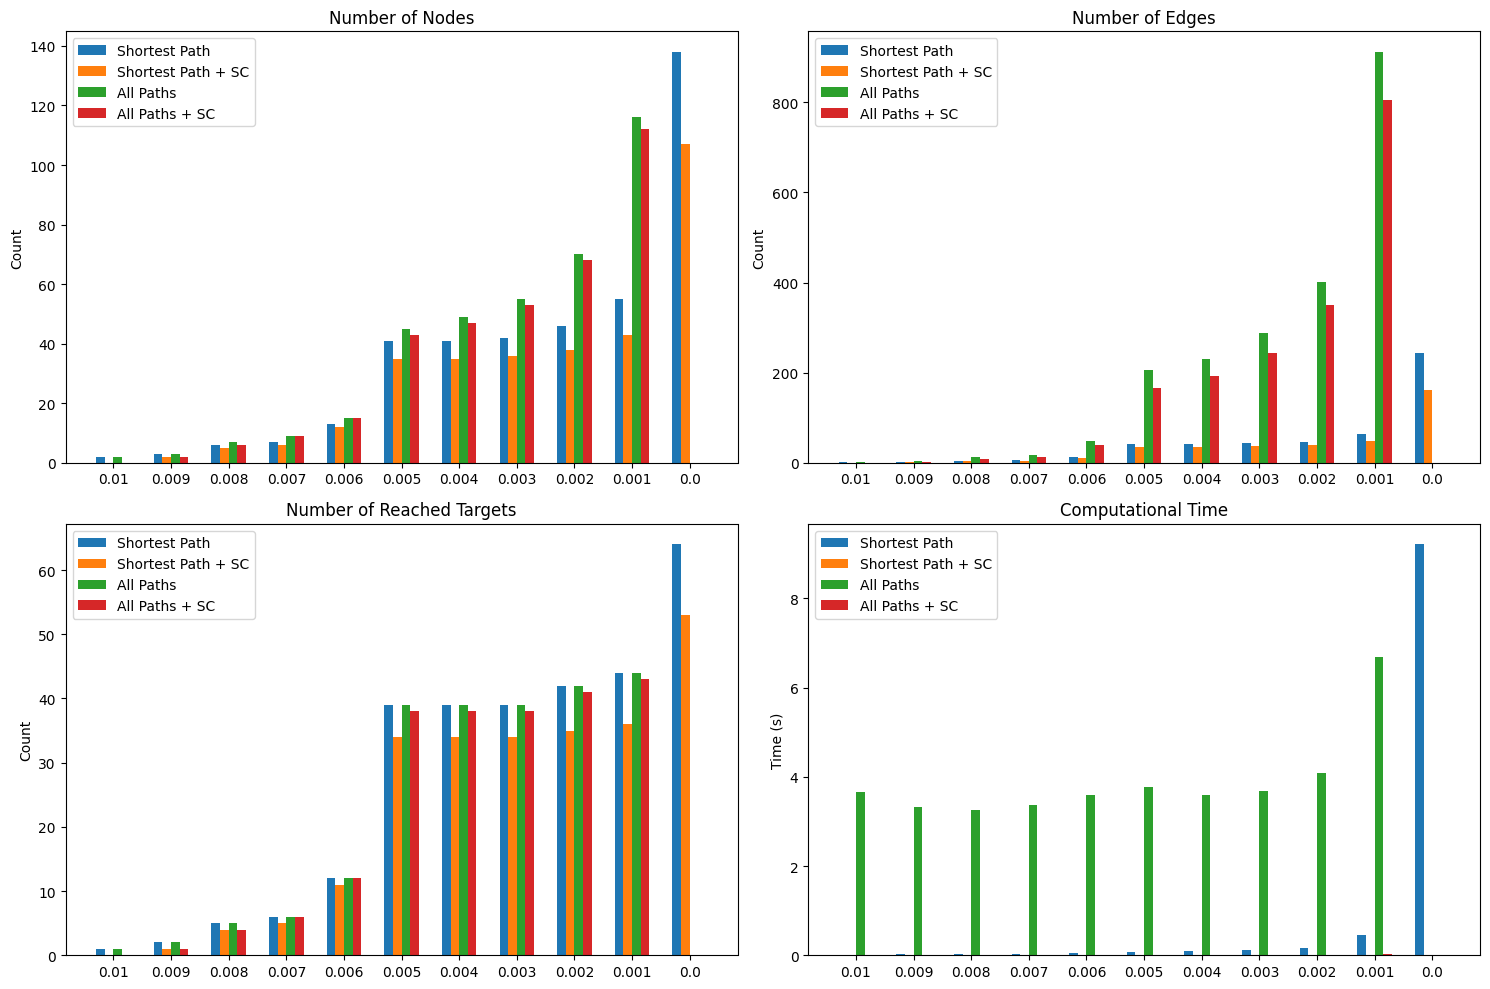

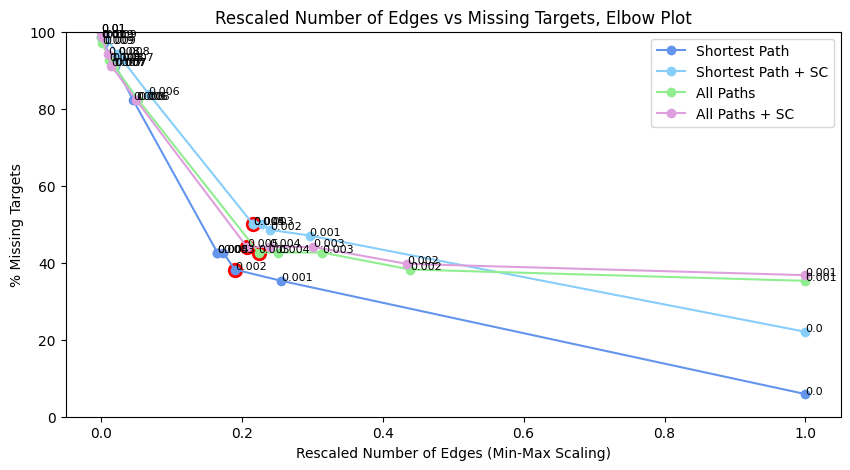

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

__pagerank_0.0__shortest v.s. __pagerank_0.0__shortest__sc: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.394e-01 U_stat=5.967e+03
__pagerank_0.0__shortest__sc v.s. __pagerank_0.002__shortest: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.138e-06 U_stat=1.201e+03
__pagerank_0.002__shortest v.s. __pagerank_0.005__shortest__sc: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.989e-07 U_stat=2.580e+02
__pagerank_0.005__shortest__sc v.s. __pagerank_0.005__reachability__allpaths: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.577e-09 U_stat=1.420e+02
__pagerank_0.005__reachability__allpaths v.s. __pagerank_0.005__reachability__allpaths__sc: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=

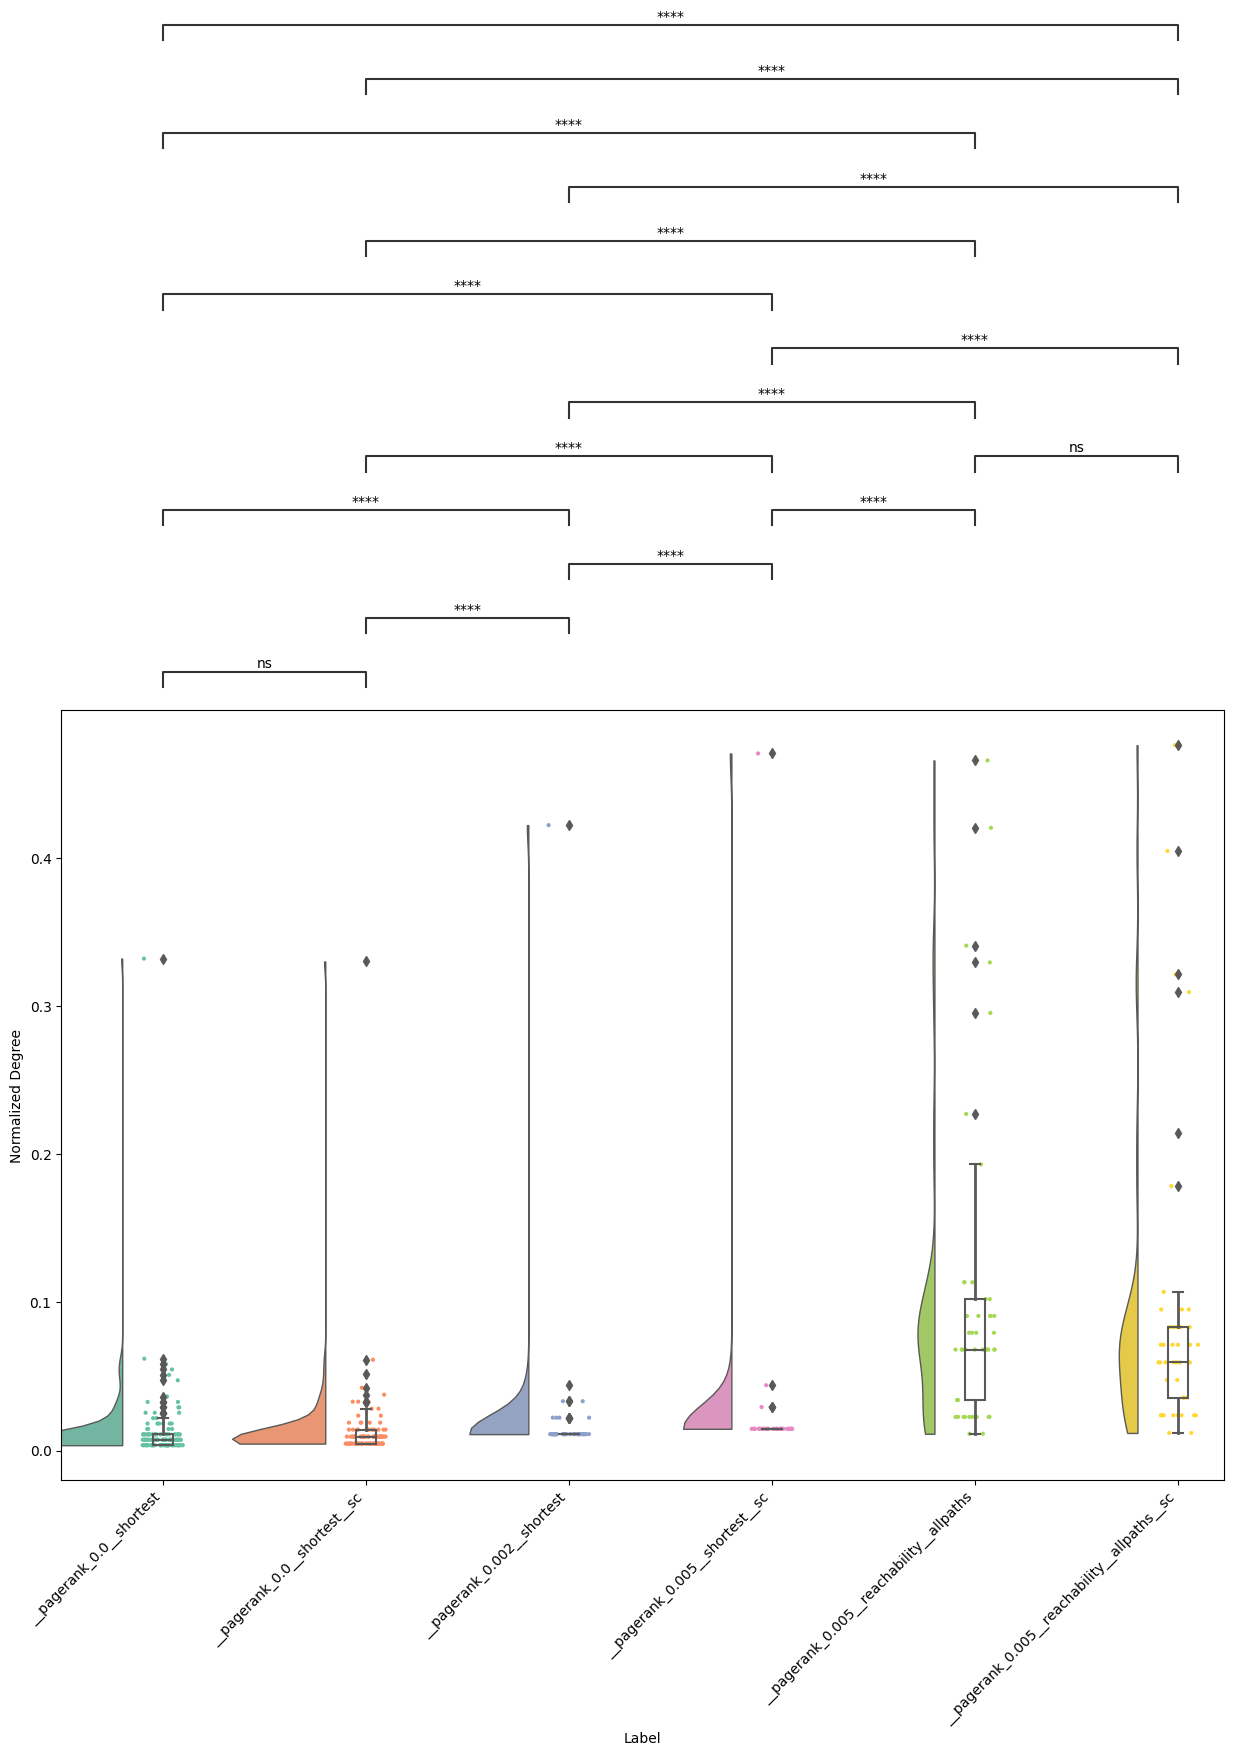

['GSE115311__reachability__pagerank_0.0__shortest__sc.sif', 'GSE115311__reachability__pagerank_0.005__reachability__allpaths.sif', 'GSE115311__reachability__pagerank_0.005__reachability__allpaths__sc.sif', 'GSE115311__reachability__pagerank_0.002__shortest.sif', 'GSE115311__reachability__pagerank_0.005__shortest__sc.sif', 'GSE115311__reachability__pagerank_0.0__shortest.sif']


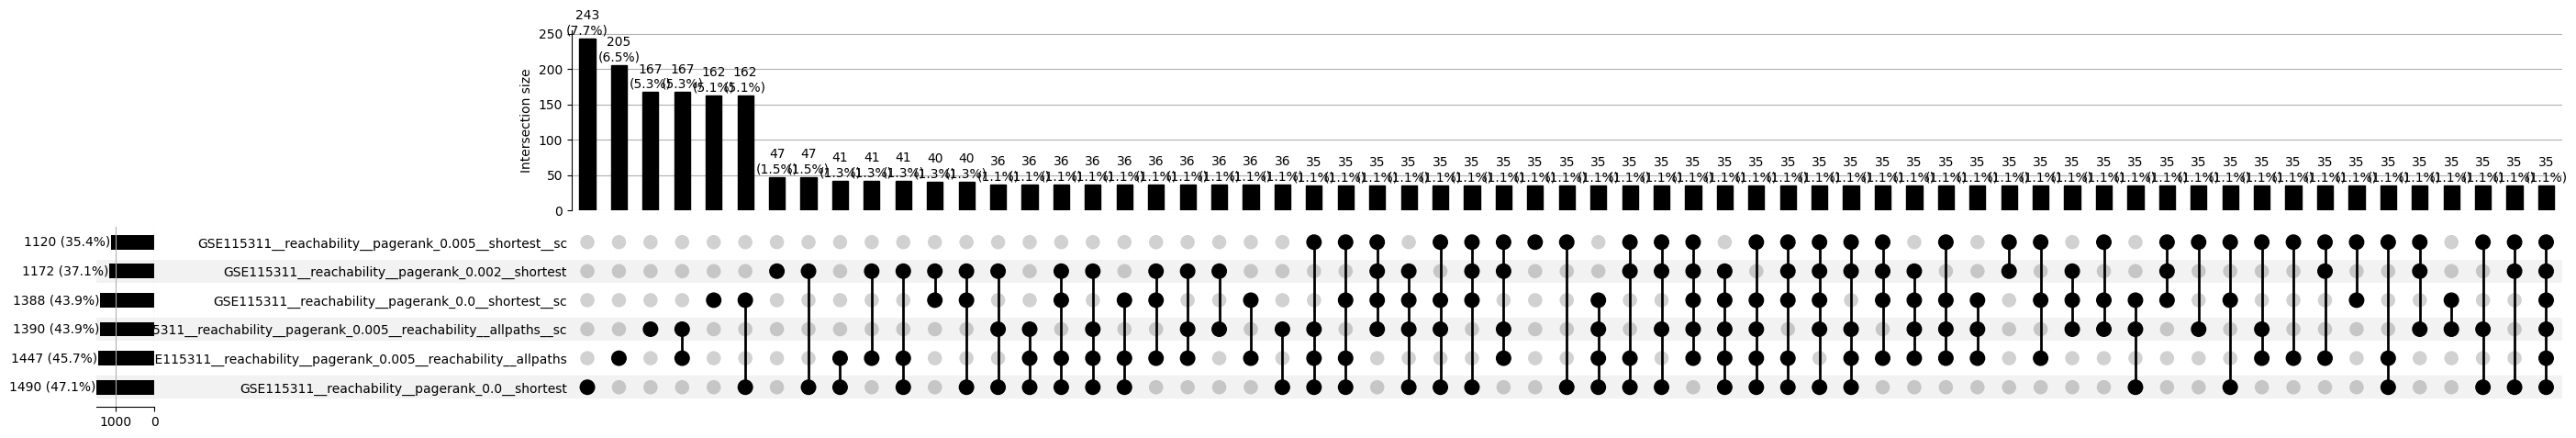

In [24]:
G3P_solver.network_batchrun()